In [2]:
import numpy as np
import pickle

# G-code generation codes are cloned from https://github.com/tibor-barsi/GcodeGenerator. Tibor Barsi is the author of the code, and was a PhD student at the Ladisk lab of the University of Ljubljana
#  We should be careful with crediting the author of the code, if we ever want to make these code public.
from src.g_code_generation_copy.gcode_generator import G_code_generator
from src.g_code_generation_copy.tool_changer_functions import save_params, load_params, printer_start, load_tool, unload_tool, tool_change, take_photo, play_sound, printer_stop
# from src.additional_functions import *
from src.network import Network_custom, replace_brackets
from compas.datastructures import Network
import os

import matplotlib.pyplot as plt

BYU_UW_root = r"G:\.shortcut-targets-by-id\1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx\Illimited Lab Projects\Research Projects\Spiders\BYU-UW"

In [11]:
def compute_perpendicular_forces(network, force_balloon, force_friction, fixed, top_ring):
    """Compute forces using the node Laplacian as a surface normal approximation."""
    forces = []
    top_ring_center = np.mean(np.array(network.nodes_attributes('xyz', keys = top_ring)), axis=0)
    for v in network.nodes():
        if v in fixed:
            forces.append(np.zeros(3))
            continue
        neighbors = network.neighbors(v)
        if network.degree(v) == 3:
            vertical_neighbor = min(neighbors, key=lambda n: network.node_attribute(n, 'z'))
            direction = np.array(network.node_attributes(v, 'xyz')) - np.array(network.node_attributes(vertical_neighbor, 'xyz'))
            direction_f = direction / np.linalg.norm(direction)

            laplacian = network.node_laplacian(vertical_neighbor)
            normal = laplacian / np.linalg.norm(laplacian)
        
            forces.append(direction_f * force_friction + normal * force_balloon) # + 
            continue
        laplacian = network.node_laplacian(v)
        normal = laplacian / np.linalg.norm(laplacian)  # Normalize
        vertical_neighbor = min(neighbors, key=lambda n: network.node_attribute(n, 'z'))
        direction = np.array(network.node_attributes(v, 'xyz')) - np.array(network.node_attributes(vertical_neighbor, 'xyz'))
        direction_f = direction / np.linalg.norm(direction)
        
        forces.append(normal * force_balloon + direction_f * force_friction)
    return np.array(forces)

def update_shape_nlf(vertices_0, loads_0, q, edges, force_balloon, force_friction, fixed, top_ring, tol = 1e-3, max_iter = 20):
    """Update the vertices of the network based on the force densities.
    parameters:
    q: list of force densities
    edges: list of edges. If not provided, the function will assume that a new q is provided for all edges in the same order as the previous q.
    """
    from compas_fd.solvers import fd_constrained_numpy
    loads = np.copy(loads_0)
    vertices = np.copy(vertices_0)
    for i in range(max_iter):
    # while True:
        result = fd_constrained_numpy(
            vertices=vertices,
            fixed= fixed,
            edges= edges,
            forcedensities=q,
            loads=loads,
            constraints= [],
        )
        vertices = np.array(result.vertices).reshape(-1, 3)
        netC = Network.from_nodes_and_edges(vertices, edges)
        loads_new = compute_perpendicular_forces(netC, force_balloon, force_friction, fixed, top_ring)
        if np.linalg.norm(loads - loads_new) < tol:
            print(f"Converged in {i} iterations.")
            break
        loads = loads_new

    f = np.array(result.forces).reshape(-1)
    l1 = np.array(result.lengths).reshape(-1)
    return vertices, f, l1, loads

def cylinder_mesh(D, H, N, M, q_circumferential, q_vertical, dq):
    """Generate vertices and edges of a cylinder with adjustable vertical segments."""
    R = D / 2  # Radius
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    z = np.linspace(0, H, M + 1)  # M vertical segments → M+1 height levels

    # Generate vertices
    vertices = np.array([[R * np.cos(t), R * np.sin(t), h] for h in z for t in theta])

    # Define edges
    edges = []
    paths = []
    q = []

    # Circumferential edges at each level
    for j in range(M + 1):
        offset = j * N
        new_path = [(offset + i, offset + (i + 1) % N) for i in range(N)]
        edges += new_path
        paths.append(new_path)
        q += list(np.ones(N) * q_circumferential)
    
    # Vertical edges between stacked layers
    for j in range(M):
        offset1, offset2 = j * N, (j + 1) * N
        new_path = [(offset1 + i, offset2 + i) for i in range(N)]
        edges += new_path
        paths.append(new_path)
        q += list(np.ones(N) * q_vertical + np.sin(theta) * dq)

    return vertices, edges, paths, q

def hoop_stress(D, P, t):
    """Compute the hoop stress in a thin-walled cylinder."""
    return P * D / (2 * t)

def axial_stress(D, P, t):
    """Compute the axial stress in a thin-walled cylinder."""
    return P / (np.pi * D * t)

def radial_displacement(D, P, t, E):
    """Compute the radial displacement in a thin-walled cylinder."""
    return P * D / (2 * t * E)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def cylinder_mesh(D, H, N, M):
    """Generate vertices and edges of a cylinder with adjustable vertical segments."""
    R = D / 2  # Radius
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    z = np.linspace(0, H, M + 1)  # M vertical segments → M+1 height levels

    # Generate vertices
    vertices = np.array([[R * np.cos(t), R * np.sin(t), h] for h in z for t in theta])

    # Define edges
    edges = []
    paths = []

    # Circumferential edges at each level
    for j in range(M + 1):
        offset = j * N
        new_path = [(offset + i, offset + (i + 1) % N) for i in range(N)]
        edges += new_path
        paths.append(new_path)
    
    # Vertical edges between stacked layers
    for j in range(M):
        offset1, offset2 = j * N, (j + 1) * N
        new_path = [(offset1 + i, offset2 + i) for i in range(N)]
        edges += new_path
        paths.append(new_path)

    return vertices, edges, paths

def apply_internal_pressure(D, t, P):
    """Compute stress components due to internal pressure."""
    R = D / 2
    sigma_hoop = P * R / t  # Hoop stress (circumferential)
    sigma_axial = P * R / (2 * t)  # Axial stress (along height)
    return sigma_hoop, sigma_axial

def bend_cylinder(vertices, H, E, I, M):
    """Apply bending deformation to cylinder vertices under a single applied moment."""
    new_vertices = vertices.copy()
    
    for i, (x, y, z) in enumerate(vertices):
        # delta_x = -(M / (6 * E * I)) * z**2 * (3 * H - z)  # Bending displacement formula
        delta_x = -(M / (2 * E * I)) * z**2
        new_vertices[i, 0] += delta_x  # Scale factor for visibility
    
    return new_vertices

def calculate_stress(D, H, M, vertices, sigma_hoop, sigma_axial, edges):
    """Calculate total stress at each vertex considering hoop, axial, and bending stress vectors."""
    R = D / 2
    I = (np.pi * R**4) / 4  # Moment of inertia for circular cross-section
    stresses = []
    edge_lengths = []
    
    for x, y, z in vertices:
        theta = np.arctan2(y, x)
        sigma_bending = -(M * R * np.cos(theta)) / I  # Bending stress varies with theta
        total_stress = np.array([sigma_hoop, sigma_axial, sigma_bending])  # [Circumferential, Axial, Bending]
        stresses.append(np.linalg.norm(total_stress))  # Compute magnitude of total stress vector
    
    for i, j in edges:
        edge_length = np.linalg.norm(vertices[i] - vertices[j])
        edge_lengths.append(edge_length)
    
    return np.array(stresses), np.array(edge_lengths)

def plot_cylinder(vertices, edges, ax, stresses):
    """Plot cylinder from vertices and edges, colorized by stress magnitude."""
    edge_lines = [[vertices[i], vertices[j]] for i, j in edges]
    colors = plt.cm.viridis((stresses - stresses.min()) / (stresses.max() - stresses.min()))
    ax.add_collection3d(Line3DCollection(edge_lines, colors=colors[:, :3], linewidths=0.5))
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], s=1, color=colors[:, :3])

D, H, N, M_sections = 5, 60, 30, 20
t = 0.01  # Wall thickness (m)
P = 100e6  # Internal pressure (Pa)
E = 200e6  # Young's modulus (Pa) for steel
I = (np.pi * (D / 2)**4) / 4  # Moment of inertia for a circular cross-section
M = 100e6  # Single applied moment

vertices, edges, _ = cylinder_mesh(D, H, N, M_sections)
sigma_hoop, sigma_axial = apply_internal_pressure(D, t, P)
deformed_vertices = bend_cylinder(vertices, H, E, I, M)
stresses, edge_lengths = calculate_stress(D, H, M, deformed_vertices, sigma_hoop, sigma_axial, edges)

%matplotlib qt
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-H/2, H/2)
ax.set_ylim(-H/2, H/2)
ax.set_zlim(0, H)

plot_cylinder(deformed_vertices, edges, ax, stresses)

plt.show()

# Store lengths and stresses in NumPy arrays
edge_lengths = np.array(edge_lengths)
stresses = np.array(stresses)


In [5]:
len(edge_lengths), len(stresses)

(1230, 630)

In [ ]:
model_name  = 'Showcase_structure_0'
D, H, N, M = 5, 60, 30, 20
q_circumferential, q_vertical = 0, 0
dq = 0
force_balloon = 0
force_friction = force_balloon * -0.1

P = 1
E = 1
t = 0.01

vertices_0, edges, paths, q = cylinder_mesh(D, H, N, M, q_circumferential, q_vertical, dq)

(0.0, 60.0)

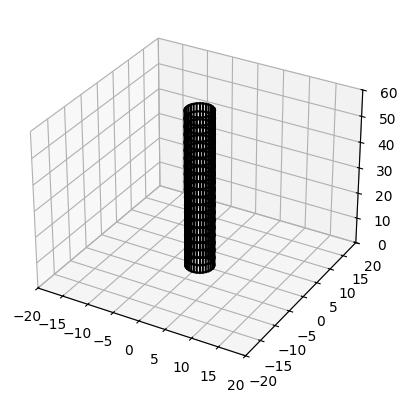

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for path in paths:
    for u, v in path:
        ax.plot(*zip(vertices_0[u], vertices_0[v]), color='black')

ax.set_xlim(-D*4, D*4)
ax.set_ylim(-D*4, D*4)
ax.set_zlim(0, H)

Define structure

In [52]:
model_name  = 'Showcase_structure_0'
D, H, N, M = 1.0, 2.0, 30, 20
q_circumferential, q_vertical = 8, .75
dq = q_vertical*0.05
force_balloon = -.18
force_friction = force_balloon * -0.1
vertices_0, edges, paths, q = cylinder_mesh(D, H, N, M, q_circumferential, q_vertical, dq)
directions  = [1]*len(edges)
fixed      = np.argwhere(vertices_0[:,2] == 0).flatten()
fixed      = fixed.tolist()
top_ring = np.argwhere(vertices_0[:,2] == H).flatten()
top_ring = top_ring.tolist()

netC = Network.from_nodes_and_edges(vertices_0, edges)
loads_0 = compute_perpendicular_forces(netC, force_balloon, force_friction, fixed, top_ring)
net = Network_custom.from_fd(vertices_0, edges, q, fixed, paths = paths, dir = directions, loads=loads_0)


%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

q_min, q_max = q_vertical - dq, q_vertical + dq
color_func = lambda x: (x - q_min) / (q_max - q_min)

for edge, q_i in zip(edges, q):
    ax.plot(*zip(*vertices_0[edge,:]), color=plt.cm.viridis(color_func(q_i)))
for v, f in zip(vertices_0, loads_0):
    ax.plot([v[0], v[0] + f[0]], [v[1], v[1] + f[1]], [v[2], v[2] + f[2]], 'r-', lw=2)
ax.set_xlim(-7, 7)
ax.set_ylim(-7, 7)
ax.set_zlim(0, 14)
plt.show()
net.q

array([8.        , 8.        , 8.        , ..., 0.72795805, 0.73474738,
       0.74220331])

In [53]:
vertices2, f2, l12, loads2 = update_shape_nlf(vertices_0, loads_0, q, edges, force_balloon, force_friction, fixed, top_ring, tol = 1e-3, max_iter = 50)

Converged in 23 iterations.


In [54]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

q_min, q_max = np.min(q), np.max(q)
color_func = lambda x: (x - q_min) / (q_max - q_min)

for edge, q_i in zip(edges, q):
    ax.plot(*zip(*vertices2[edge,:]), color=plt.cm.viridis(color_func(q_i)))
for v, f in zip(vertices2, loads2):
    ax.plot([v[0], v[0] + f[0]], [v[1], v[1] + f[1]], [v[2], v[2] + f[2]], 'r-', lw=2)
# ax.set_xlim(-7, 7)
# ax.set_ylim(-7, 7)
# ax.set_zlim(0, 14)
plt.show()

In [ ]:
netC2  = Network.from_nodes_and_edges(net.vertices, edges)
forces2 = compute_perpendicular_forces(netC2, force_balloon, force_friction, fixed, top_ring)
net2 = Network_custom.from_fd(net.vertices, edges, q, fixed, paths = paths, dir = directions, loads=forces2)

In [ ]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for edge in edges:
    ax.plot(*zip(*net2.vertices[edge,:]), color='b')
for v, f in zip(net2.vertices, forces2):
    ax.plot([v[0], v[0] + f[0]], [v[1], v[1] + f[1]], [v[2], v[2] + f[2]], 'r-', lw=2)
ax.set_xlim(-7, 7)
ax.set_ylim(-7, 7)
ax.set_zlim(0, 14)
plt.show()

In [ ]:
net.net_plot(elables=False)